# CNN Model
##### Some basic augmentation
##### With weighing
##### Batch size defined
##### Combined vgg16 with additional layers

##### 600 positive cases
##### 5000 negative cases
##### hyperparameter tuning

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import keras.backend as K

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers


import csv
import random
import pickle


## Load downsampled dataset

In [2]:
# Load the compressed array from disk
images_mini_norm = np.load('CNN_Xs_downsample_forvgg16.npz')['data']

In [3]:
# load the labels from disk
with open('CNN_labels_downsampled_forvgg16.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [4]:
print('images_mini.shape:', images_mini_norm.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (5600, 224, 224, 3)

number of labels: 5600

number of positive cancer cases: 600


In [5]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 255.0
Confirm min pixel value is 0: 0.0


## Visualize image transformations

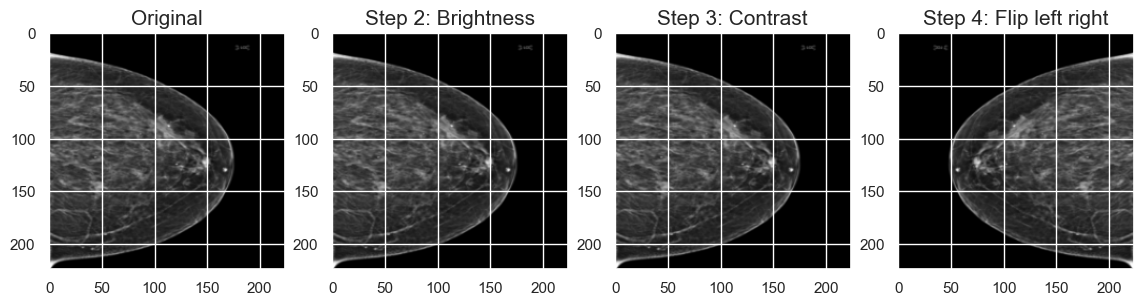

In [6]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini_norm[0]

# plot original
ax = fig.add_subplot(1, 4, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);


# adjust brightness
ax = fig.add_subplot(1, 4, 2)
img_bright = tf.image.adjust_brightness(image, -.8)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 4, 3)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 4, 4)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);


## Split data into train, validate, test

In [7]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; 
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images = images[shuffle]
    y = y[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini_norm,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"y_train positive cases {sum(y_train)}\n")

print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"y_val positive cases {sum(y_val)}\n")

print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")
print(f"y_test positive cases {sum(y_test)}\n")

X_train shape (3360, 224, 224, 3)
y_train shape (3360,)
y_train positive cases 371

X_val shape (1120, 224, 224, 3)
y_val shape (1120,)
y_val positive cases 114

X_test shape (1120, 224, 224, 3)
y_test shape (1120,)
y_test positive cases 115



## Augmentation function

In [9]:
def preprocess_augm(X_train, y_train):
    
    # Augment only cancer=1 data
    X_train_w_cancer = X_train[y_train == 1, :, :, :]
    y_train_w_cancer = y_train[y_train == 1]
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm1 = tf.image.adjust_brightness(X_train_w_cancer, delta=.1)
    X_train_augm2 = tf.image.adjust_brightness(X_train_w_cancer, delta=.2)
    
    # adjust contrast
    X_train_augm5 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=1)
    X_train_augm6 = tf.image.adjust_contrast(X_train_w_cancer, contrast_factor=2)

    # random flip
    X_train_augm8 = tf.image.random_flip_left_right(X_train_w_cancer)
    
    # concatenate augmented X_train data
    X_train_augm = tf.concat([X_train_augm1, X_train_augm2, X_train_augm5,
                        X_train_augm6, X_train_augm8],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = tf.convert_to_tensor(np.ones(len(X_train_augm)))
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train_augm)[0], dtype=tf.int32))
    X_train_augm = tf.gather(X_train_augm, shuffle)
    y_train_augm = tf.gather(y_train_augm, shuffle)
    
    return X_train_augm, y_train_augm

# Run the function
X_train_augm, y_train_augm = preprocess_augm(X_train, y_train)

In [10]:
X_train_augm.shape

TensorShape([1855, 224, 224, 3])

In [11]:
def preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm):
    X_train_augm = X_train_augm[0:n_augm]
    y_train_augm = y_train_augm[0:n_augm]
    
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train

#X_train, y_train = preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm=2000)

## Calculate class weights function

In [12]:
def calc_class_weights(class_weight_binary, y_train):
    if class_weight_binary:
        total = len(y_train)
        pos = sum(y_train)
        neg = total - pos
        print('pos:', pos)
        print('neg:', neg)
        print('total', total)

        # Scaling by total/2 helps keep the loss to a similar magnitude.
        # The sum of the weights of all examples stays the same.
        weight_for_0 = (1 / neg) * (total / 2.0)
        weight_for_1 = (1 / pos) * (total / 2.0)

        class_weights = {0: weight_for_0, 1: weight_for_1}

        print('Weight for class 0: {:.2f}'.format(weight_for_0))
        print('Weight for class 1: {:.2f}'.format(weight_for_1))
    else:
        class_weights = {0: 0.5, 1: 0.5}
    
    return class_weights

## Define recall, precision, f1

In [13]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Build vgg16 model function

In [14]:
import itertools

def train_test_model(params, X_train, y_train, X_train_augm, y_train_augm, X_val, y_val):
    num_units=params['num_units']
    dropout_rate = params['dropout_rate']
    optimizer = params['optimizer']
    n_epochs = params['n_epochs']
    batch_size = params['batch_size']
    class_weight_binary = params['class_weight_binary']
    pool_size = params['pool_size']
    n_augm = params['n_augm']
    
    IMG_SIZE = 224
    IMG_SHAPE = ( IMG_SIZE, IMG_SIZE, 3)
    VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    VGG16_MODEL.trainable=False
    global_max_layer = tf.keras.layers.MaxPool2D(pool_size=(pool_size, pool_size))
    flatten_layer = tf.keras.layers.Flatten()
    extra_dense_layer = tf.keras.layers.Dense(units=num_units, activation='relu')
    dropout_layer = tf.keras.layers.Dropout(rate=dropout_rate)
    prediction_layer = tf.keras.layers.Dense(units=1,activation='sigmoid')


    model = tf.keras.Sequential([
      VGG16_MODEL,
      global_max_layer,
      flatten_layer,
      extra_dense_layer,
      dropout_layer,
      prediction_layer
    ])

    print(model.summary())

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['AUC','accuracy', recall_m, precision_m, f1_m])

    X_train, y_train = preprocess_augm_part2(X_train, y_train, X_train_augm, y_train_augm, n_augm=n_augm)
    class_weights = calc_class_weights(class_weight_binary, y_train)

    history = model.fit(X_train, y_train,
                        epochs=n_epochs, 
                        validation_data=(X_val, y_val),
                        class_weight=class_weights,
                        batch_size = batch_size
                       )
    

    hist = history.history
    accuracy = hist['val_accuracy'][0]
    f1 = hist['val_f1_m'][0]
    auc = hist['val_auc'][0]
    recall = hist['val_recall_m'][0]
    precision = hist['val_precision_m'][0]
    
    return accuracy, f1, auc, recall, precision

# Define the number of parameter combinations to sample
n_combinations = 20

with open('results4.txt', 'w') as f:
    # Loop over random parameter combinations and train/evaluate your model
    for i in range(n_combinations):
        param_dict = {
            'num_units': random.choice([32]),
            'dropout_rate': random.choice([0.3, 0.9]),
            'optimizer': random.choice(['adam']),
            'n_epochs': random.choice([10]),
            'batch_size': random.choice([50]),
            'class_weight_binary': random.choice([1]),
            'pool_size': random.choice([4,5,6]),
            'n_augm': random.choice([200])
        }
        print(param_dict)
        metric_value = train_test_model(param_dict, X_train, y_train, X_train_augm, y_train_augm, X_val, y_val)
        result = [param_dict, metric_value]
        # Write the result to the file
        f.write(str(result) + '\n')

{'num_units': 32, 'dropout_rate': 0.9, 'optimizer': 'adam', 'n_epochs': 10, 'batch_size': 50, 'class_weight_binary': 1, 'pool_size': 4, 'n_augm': 200}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                     

72/72 [==============================] - 214s 3s/step - loss: 0.6980 - auc: 0.5007 - accuracy: 0.1618 - recall_m: 0.9861 - precision_m: 0.1589 - f1_m: 0.2707 - val_loss: 0.6913 - val_auc: 0.5123 - val_accuracy: 0.1187 - val_recall_m: 1.0000 - val_precision_m: 0.1050 - val_f1_m: 0.1875
Epoch 9/10
72/72 [==============================] - 214s 3s/step - loss: 0.7018 - auc: 0.4894 - accuracy: 0.1638 - recall_m: 0.9989 - precision_m: 0.1601 - f1_m: 0.2727 - val_loss: 0.6918 - val_auc: 0.5118 - val_accuracy: 0.1179 - val_recall_m: 0.9873 - val_precision_m: 0.1036 - val_f1_m: 0.1850
Epoch 10/10
72/72 [==============================] - 213s 3s/step - loss: 0.6923 - auc: 0.5007 - accuracy: 0.3958 - recall_m: 0.6389 - precision_m: 0.0989 - f1_m: 0.1692 - val_loss: 0.6894 - val_auc: 0.5099 - val_accuracy: 0.1205 - val_recall_m: 0.9829 - val_precision_m: 0.1038 - val_f1_m: 0.1853
{'num_units': 32, 'dropout_rate': 0.9, 'optimizer': 'adam', 'n_epochs': 10, 'batch_size': 50, 'class_weight_binary': 1,

72/72 [==============================] - 213s 3s/step - loss: 0.6806 - auc: 0.5348 - accuracy: 0.2376 - recall_m: 0.9360 - precision_m: 0.1669 - f1_m: 0.2788 - val_loss: 0.6933 - val_auc: 0.4811 - val_accuracy: 0.1804 - val_recall_m: 0.8304 - val_precision_m: 0.0962 - val_f1_m: 0.1701
Epoch 6/10
72/72 [==============================] - 213s 3s/step - loss: 0.6764 - auc: 0.5291 - accuracy: 0.2404 - recall_m: 0.9649 - precision_m: 0.1714 - f1_m: 0.2854 - val_loss: 0.6929 - val_auc: 0.4725 - val_accuracy: 0.2241 - val_recall_m: 0.7404 - val_precision_m: 0.0936 - val_f1_m: 0.1637
Epoch 7/10
72/72 [==============================] - 213s 3s/step - loss: 0.6684 - auc: 0.5576 - accuracy: 0.2722 - recall_m: 0.9342 - precision_m: 0.1733 - f1_m: 0.2885 - val_loss: 0.6743 - val_auc: 0.4852 - val_accuracy: 0.3661 - val_recall_m: 0.6194 - val_precision_m: 0.0960 - val_f1_m: 0.1629
Epoch 8/10
72/72 [==============================] - 214s 3s/step - loss: 0.6599 - auc: 0.5789 - accuracy: 0.3346 - recal

72/72 [==============================] - 213s 3s/step - loss: 0.7287 - auc: 0.5039 - accuracy: 0.1823 - recall_m: 0.9854 - precision_m: 0.1628 - f1_m: 0.2765 - val_loss: 0.6557 - val_auc: 0.5182 - val_accuracy: 0.2937 - val_recall_m: 0.8256 - val_precision_m: 0.1080 - val_f1_m: 0.1877
Epoch 3/10
72/72 [==============================] - 213s 3s/step - loss: 0.7047 - auc: 0.5005 - accuracy: 0.1758 - recall_m: 0.9870 - precision_m: 0.1620 - f1_m: 0.2753 - val_loss: 0.6879 - val_auc: 0.5154 - val_accuracy: 0.1634 - val_recall_m: 0.9473 - val_precision_m: 0.1057 - val_f1_m: 0.1875
Epoch 4/10
72/72 [==============================] - 215s 3s/step - loss: 0.6985 - auc: 0.5011 - accuracy: 0.1654 - recall_m: 0.9988 - precision_m: 0.1604 - f1_m: 0.2727 - val_loss: 0.6821 - val_auc: 0.5091 - val_accuracy: 0.1696 - val_recall_m: 0.9386 - val_precision_m: 0.1054 - val_f1_m: 0.1868
Epoch 5/10
72/72 [==============================] - 213s 3s/step - loss: 0.7073 - auc: 0.4920 - accuracy: 0.1680 - recal

                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14,731,137
Trainable params: 16,449
Non-trainable params: 14,714,688
_________________________________________________________________
None
pos: 571.0
neg: 2989.0
total 3560
Weight for class 0: 0.60
Weight for class 1: 3.12
Epoch 1/10
72/72 [==============================] - 219s 3s/step - loss: 3.7485 - auc: 0.4730 - accuracy: 0.2258 - recall_m: 0.8735 - precision_m: 0.1567 - f1_m: 0.2609 - val_loss: 0.7239 - val_auc: 0.4936 - val_accuracy: 0.1875 - val_recall_m: 0.9031 - val_precision_m: 0.1032 - val_f1_m: 0.1824
Epoch 2/10
72/72 [==============================] - 214s 3s/step - loss: 0.7406 - auc: 0.4785 - accuracy: 0.1660 - recall_m: 0.9878 - precision_m: 0.1603 - f1_m: 0.2723 - val_loss: 0.7107 - val_auc: 0.4993 - val_accuracy: 0.1634 - val_recall_m: 0.9464 - val_precision

 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 1, 1, 512)        0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 32)                16416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14,731,137
Trainable params: 16,449
Non-trainable params: 14,7

72/72 [==============================] - 215s 3s/step - loss: 0.6608 - auc: 0.6143 - accuracy: 0.6520 - recall_m: 0.4134 - precision_m: 0.2591 - f1_m: 0.2496 - val_loss: 0.6454 - val_auc: 0.5332 - val_accuracy: 0.7821 - val_recall_m: 0.1283 - val_precision_m: 0.1266 - val_f1_m: 0.1207
Epoch 10/10
72/72 [==============================] - 213s 3s/step - loss: 0.6367 - auc: 0.6279 - accuracy: 0.6531 - recall_m: 0.4192 - precision_m: 0.2518 - f1_m: 0.2451 - val_loss: 0.5973 - val_auc: 0.5430 - val_accuracy: 0.8518 - val_recall_m: 0.0550 - val_precision_m: 0.0978 - val_f1_m: 0.0681
{'num_units': 32, 'dropout_rate': 0.3, 'optimizer': 'adam', 'n_epochs': 10, 'batch_size': 50, 'class_weight_binary': 1, 'pool_size': 6, 'n_augm': 200}
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                            

72/72 [==============================] - 214s 3s/step - loss: 0.6799 - auc: 0.5502 - accuracy: 0.7713 - recall_m: 0.2007 - precision_m: 0.2703 - f1_m: 0.2104 - val_loss: 0.7059 - val_auc: 0.5233 - val_accuracy: 0.7670 - val_recall_m: 0.2012 - val_precision_m: 0.1228 - val_f1_m: 0.1388
Epoch 7/10
72/72 [==============================] - 213s 3s/step - loss: 0.6756 - auc: 0.5744 - accuracy: 0.7601 - recall_m: 0.2540 - precision_m: 0.2804 - f1_m: 0.2473 - val_loss: 0.6688 - val_auc: 0.5400 - val_accuracy: 0.8464 - val_recall_m: 0.0786 - val_precision_m: 0.1334 - val_f1_m: 0.0885
Epoch 8/10
72/72 [==============================] - 213s 3s/step - loss: 0.6776 - auc: 0.5603 - accuracy: 0.7885 - recall_m: 0.1527 - precision_m: 0.2640 - f1_m: 0.1617 - val_loss: 0.6456 - val_auc: 0.5500 - val_accuracy: 0.8277 - val_recall_m: 0.1138 - val_precision_m: 0.1036 - val_f1_m: 0.1023
Epoch 9/10
72/72 [==============================] - 213s 3s/step - loss: 0.6585 - auc: 0.5999 - accuracy: 0.7646 - recal

72/72 [==============================] - 213s 3s/step - loss: 0.7255 - auc: 0.5010 - accuracy: 0.1635 - recall_m: 0.9986 - precision_m: 0.1644 - f1_m: 0.2771 - val_loss: 0.6960 - val_auc: 0.5079 - val_accuracy: 0.1214 - val_recall_m: 0.9952 - val_precision_m: 0.1045 - val_f1_m: 0.1867
Epoch 4/10
72/72 [==============================] - 213s 3s/step - loss: 0.6928 - auc: 0.5003 - accuracy: 0.1624 - recall_m: 0.9931 - precision_m: 0.1598 - f1_m: 0.2711 - val_loss: 0.6942 - val_auc: 0.5069 - val_accuracy: 0.1196 - val_recall_m: 0.9952 - val_precision_m: 0.1041 - val_f1_m: 0.1861
Epoch 5/10
72/72 [==============================] - 213s 3s/step - loss: 0.6972 - auc: 0.5012 - accuracy: 0.1632 - recall_m: 1.0000 - precision_m: 0.1614 - f1_m: 0.2744 - val_loss: 0.6933 - val_auc: 0.5089 - val_accuracy: 0.1223 - val_recall_m: 0.9952 - val_precision_m: 0.1044 - val_f1_m: 0.1865
Epoch 6/10
72/72 [==============================] - 214s 3s/step - loss: 0.6925 - auc: 0.4788 - accuracy: 0.1618 - recal

Non-trainable params: 14,714,688
_________________________________________________________________
None
pos: 571.0
neg: 2989.0
total 3560
Weight for class 0: 0.60
Weight for class 1: 3.12
Epoch 1/10
72/72 [==============================] - 218s 3s/step - loss: 4.6634 - auc: 0.4861 - accuracy: 0.2323 - recall_m: 0.8773 - precision_m: 0.1580 - f1_m: 0.2610 - val_loss: 0.7013 - val_auc: 0.4848 - val_accuracy: 0.1232 - val_recall_m: 0.9440 - val_precision_m: 0.1007 - val_f1_m: 0.1796
Epoch 2/10
72/72 [==============================] - 214s 3s/step - loss: 0.6938 - auc: 0.5005 - accuracy: 0.1615 - recall_m: 1.0000 - precision_m: 0.1633 - f1_m: 0.2765 - val_loss: 0.7019 - val_auc: 0.4853 - val_accuracy: 0.1241 - val_recall_m: 0.9440 - val_precision_m: 0.1008 - val_f1_m: 0.1796
Epoch 3/10
72/72 [==============================] - 215s 3s/step - loss: 0.6926 - auc: 0.5013 - accuracy: 0.1638 - recall_m: 0.9980 - precision_m: 0.1612 - f1_m: 0.2738 - val_loss: 0.7027 - val_auc: 0.4981 - val_accura

 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 32)                16416     
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14,731,137
Trainable params: 16,449
Non-trainable params: 14,714,688
_________________________________________________________________
None
pos: 571.0
neg: 2989.0
total 3560
Weight for class 0: 0.60
Weight for class 1: 3.12
Epoch 1/10
72/72 [==============================] - 222s 3s/step - loss: 6.2529 - auc: 0.5072 - accura

72/72 [==============================] - 213s 3s/step - loss: 0.6176 - auc: 0.7052 - accuracy: 0.7084 - recall_m: 0.5491 - precision_m: 0.2916 - f1_m: 0.3661 - val_loss: 0.6221 - val_auc: 0.6023 - val_accuracy: 0.7214 - val_recall_m: 0.3264 - val_precision_m: 0.1323 - val_f1_m: 0.1793
